## <p style = "text-align: center; font-weight: bold;">Analyzing top airlines review</p>

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Importing Data</p>
-----------------------------------------------------------------------------------------

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, to_date, col, regexp_replace, length, mean, monotonically_increasing_id
from tqdm import tqdm

In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Load Airlines Reviews") \
    .getOrCreate()

# Load data from CSV file
df = spark.read.csv("Datasets/airlines_reviews.csv", header=True, inferSchema=True, multiLine=True, escape='"') # multiLine=True, escape='"' to handle multiline reviews

24/04/12 14:13:37 WARN Utils: Your hostname, Bikins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.53 instead (on interface en0)
24/04/12 14:13:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/12 14:13:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Checking Data for cleaning</b>
-----------------------------------------------------------------------------------------

In [3]:
# Print the schema
df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Review Date: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Verified: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Type of Traveller: string (nullable = true)
 |-- Month Flown: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Seat Comfort: integer (nullable = true)
 |-- Staff Service: integer (nullable = true)
 |-- Food & Beverages: integer (nullable = true)
 |-- Inflight Entertainment: integer (nullable = true)
 |-- Value For Money: integer (nullable = true)
 |-- Overall Rating: integer (nullable = true)
 |-- Recommended: string (nullable = true)



In [4]:
# Show the dataframe
df.show()

+--------------------+----------------+-----------+------------------+--------+--------------------+-----------------+-------------+--------------------+--------------+------------+-------------+----------------+----------------------+---------------+--------------+-----------+
|               Title|            Name|Review Date|           Airline|Verified|             Reviews|Type of Traveller|  Month Flown|               Route|         Class|Seat Comfort|Staff Service|Food & Beverages|Inflight Entertainment|Value For Money|Overall Rating|Recommended|
+--------------------+----------------+-----------+------------------+--------+--------------------+-----------------+-------------+--------------------+--------------+------------+-------------+----------------+----------------------+---------------+--------------+-----------+
|  Flight was amazing|Alison Soetantyo| 2024-03-01|Singapore Airlines|    True|  Flight was amaz...|     Solo Leisure|December 2023|Jakarta to Singapore|Business C

In [5]:
# Show total review count
total_reviews = df.count()
print("Total reviews:", total_reviews)

Total reviews: 8100


In [6]:
# Show unique airlines
df.select("Airline").distinct().show(truncate=False)

+----------------------+
|Airline               |
+----------------------+
|EVA Air               |
|Turkish Airlines      |
|Qatar Airways         |
|Air France            |
|Japan Airlines        |
|Cathay Pacific Airways|
|All Nippon Airways    |
|Emirates              |
|Singapore Airlines    |
|Korean Air            |
+----------------------+



In [7]:
# Show unique recommended values
df.select("Recommended").distinct().show(truncate=False)

+-----------+
|Recommended|
+-----------+
|no         |
|yes        |
+-----------+



In [8]:
# Checking for human errors in scoring
df.filter(df["Overall Rating"] == 1).orderBy("Seat Comfort", "Staff Service", "Food & Beverages", "Inflight Entertainment", "Value For Money", ascending=False).select("Seat Comfort", "Staff Service", "Food & Beverages", "Inflight Entertainment", "Value For Money", "Overall Rating").show()

+------------+-------------+----------------+----------------------+---------------+--------------+
|Seat Comfort|Staff Service|Food & Beverages|Inflight Entertainment|Value For Money|Overall Rating|
+------------+-------------+----------------+----------------------+---------------+--------------+
|           5|            5|               5|                     5|              3|             1|
|           5|            5|               5|                     5|              2|             1|
|           5|            5|               5|                     5|              2|             1|
|           5|            5|               5|                     5|              1|             1|
|           5|            5|               5|                     5|              1|             1|
|           5|            5|               5|                     5|              1|             1|
|           5|            5|               5|                     5|              1|             1|


-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Cleaning</p>
-----------------------------------------------------------------------------------------

In [9]:
# Convert Month Flown to date format
df = df.withColumn("Month Flown", to_date(df["Month Flown"], "MMMM yyyy"))

# Convert Recommended to boolean
df = df.withColumn("Recommended", col("Recommended").cast("boolean"))

df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Review Date: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Verified: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Type of Traveller: string (nullable = true)
 |-- Month Flown: date (nullable = true)
 |-- Route: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Seat Comfort: integer (nullable = true)
 |-- Staff Service: integer (nullable = true)
 |-- Food & Beverages: integer (nullable = true)
 |-- Inflight Entertainment: integer (nullable = true)
 |-- Value For Money: integer (nullable = true)
 |-- Overall Rating: integer (nullable = true)
 |-- Recommended: boolean (nullable = true)



In [10]:
# Change special characters in Title
df = df.withColumn("Title", regexp_replace(df["Title"], "\"", ""))
df = df.withColumn("Title", regexp_replace(df["Title"], "“|”", ""))
df = df.withColumn("Reviews", regexp_replace(df["Title"], "\"", ""))
df = df.withColumn("Reviews", regexp_replace(df["Title"], "“|”", ""))

In [11]:
from pyspark.sql.functions import col
# Create a dataframe with only necessary columns
selected_df = df.select(col("Title").alias("Review Title"), col("Name").alias("Reviewer"), "Review Date", "Airline", col("Reviews").alias("Review Content"), col("Month Flown").alias("Flight Date"), "Class", "Seat Comfort", "Staff Service", "Food & Beverages", "Inflight Entertainment", "Value For Money", "Overall Rating", "Recommended")


# Convert Overall Rating from out of 10 to out of 5
selected_df = selected_df.withColumn("Overall Rating", col("Overall Rating") / 2)

# Calculate the corrected overall rating
selected_df = selected_df.withColumn("Corrected Overall Rating", (col("Seat Comfort") + col("Staff Service") + col("Food & Beverages") + col("Inflight Entertainment") + col("Value For Money")) / 5)

# Add an auto-incremental Review ID column
selected_df = selected_df.withColumn("Review ID", monotonically_increasing_id())

selected_df.show()

+--------------------+----------------+-----------+------------------+--------------------+-----------+--------------+------------+-------------+----------------+----------------------+---------------+--------------+-----------+------------------------+---------+
|        Review Title|        Reviewer|Review Date|           Airline|      Review Content|Flight Date|         Class|Seat Comfort|Staff Service|Food & Beverages|Inflight Entertainment|Value For Money|Overall Rating|Recommended|Corrected Overall Rating|Review ID|
+--------------------+----------------+-----------+------------------+--------------------+-----------+--------------+------------+-------------+----------------+----------------------+---------------+--------------+-----------+------------------------+---------+
|  Flight was amazing|Alison Soetantyo| 2024-03-01|Singapore Airlines|  Flight was amazing| 2023-12-01|Business Class|           4|            4|               4|                     4|              4|       

In [12]:
selected_df.printSchema()

root
 |-- Review Title: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Review Date: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Review Content: string (nullable = true)
 |-- Flight Date: date (nullable = true)
 |-- Class: string (nullable = true)
 |-- Seat Comfort: integer (nullable = true)
 |-- Staff Service: integer (nullable = true)
 |-- Food & Beverages: integer (nullable = true)
 |-- Inflight Entertainment: integer (nullable = true)
 |-- Value For Money: integer (nullable = true)
 |-- Overall Rating: double (nullable = true)
 |-- Recommended: boolean (nullable = true)
 |-- Corrected Overall Rating: double (nullable = true)
 |-- Review ID: long (nullable = false)



-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Analysis</p>
-----------------------------------------------------------------------------------------

In [13]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


In [46]:
# Group by 'Flight Date' and calculate the average 'Overall Rating'
average_ratings_by_date = selected_df.groupBy('Flight Date').agg(avg('Corrected Overall Rating').alias('Overall Rating Average'))

average_ratings_by_date.count()

# Convert the DataFrame to Pandas
average_ratings_by_date_pd = average_ratings_by_date.toPandas()

# Create the scatter plot
fig = px.scatter(average_ratings_by_date_pd, x='Flight Date', y='Overall Rating Average', title='Customer Satisfaction Over Time')

fig.show()

In [48]:
# Convert 'Flight Date' to datetime.datetime
average_ratings_by_date_pd['Flight Date'] = pd.to_datetime(average_ratings_by_date_pd['Flight Date'])

# Create a scatter plot
fig = px.scatter(average_ratings_by_date_pd, x='Flight Date', y='Overall Rating Average', trendline='ols', title='Correlation between Flight Date and Customer Satisfaction')

# Show the plot
fig.show()

In [49]:
# Calculate the average overall rating for each class
average_ratings_by_class = selected_df.groupBy("Class").agg(avg("Overall Rating").alias('Overall Rating Average'))

# Convert the DataFrame to Pandas
average_ratings_by_class_pd = average_ratings_by_class.toPandas()

# Find the highest and lowest average overall ratings
highest_rating = average_ratings_by_class_pd["Overall Rating Average"].max()
lowest_rating = average_ratings_by_class_pd["Overall Rating Average"].min()

# Create the bar chart
fig = px.bar(average_ratings_by_class_pd, x='Class', y='Overall Rating Average', title='Average Ratings by Class')

# Highlight the highest and lowest ratings
fig.update_traces(marker_color=['red' if rating == lowest_rating else 'lightblue' for rating in average_ratings_by_class_pd["Overall Rating Average"]])


# Set the maximum scale of the y-axis to 5
fig.update_layout(yaxis_range=[0, 5])

# Show the bar chart
fig.show()

In [17]:
# Filter the DataFrame for the economy class
economy_df = selected_df.filter(selected_df["Class"] == "Economy Class")

# Calculate the average overall rating for each airline
average_ratings = economy_df.groupBy("Airline").agg(avg("Overall Rating").alias('Overall Rating Average'))

# Create a pandas dataframe from the average ratings
average_ratings_df = average_ratings.toPandas()

# Find the highest and lowest average overall ratings
highest_rating = average_ratings_df["Overall Rating Average"].max()
lowest_rating = average_ratings_df["Overall Rating Average"].min()

# Create the bar chart
fig = px.bar(average_ratings_df, x='Airline', y='Overall Rating Average', title='Average Ratings for Each Airline (Economy Class)')

# Highlight the highest and lowest ratings
fig.update_traces(marker_color=['green' if rating == highest_rating else 'red' if rating == lowest_rating else 'lightblue' for rating in average_ratings_df["Overall Rating Average"]])

# Set the maximum scale of the y-axis to 5
fig.update_layout(yaxis_range=[0, 5])

fig.show()

In [18]:
# Group by 'Airline' and calculate the mean of each category
average_ratings = economy_df.groupBy("Airline").agg(
    F.mean("Seat Comfort").alias("Seat Comfort"),
    F.mean("Staff Service").alias("Staff Service"),
    F.mean("Food & Beverages").alias("Food & Beverages"),
    F.mean("Inflight Entertainment").alias("Inflight Entertainment"),
    F.mean("Value For Money").alias("Value For Money")
)

# Convert the DataFrame to Pandas
average_ratings_pd = average_ratings.toPandas()

# Create the bar chart
fig = go.Figure()

# Iterate over each category and add a bar trace for each airline
for category in average_ratings_pd.columns[1:]:
    fig.add_trace(go.Bar(x=average_ratings_pd["Airline"], y=average_ratings_pd[category], name=category))

# Update the layout of the bar chart
fig.update_layout(title="Average Ratings by Category for Each Airline (Economy Class)",
                  xaxis_title="Airline",
                  yaxis_title="Average Rating",
                  yaxis_range=[0, 5],
                  barmode="group",
                  showlegend=True,
                  legend=dict(x=1, y=0, bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='rgba(0, 0, 0, 0.5)'),
                  height=600,
                  width=1000)

# Show the bar chart
fig.show()

In [42]:
correlation1 = economy_df.corr("Seat Comfort", "Overall Rating")
print("Correlation between Value for Money and Seat Comfort:", correlation1)

correlation2 = economy_df.corr("Staff Service", "Overall Rating")
print("Correlation between Value for Money and Seat Comfort:", correlation2)

correlation3 = economy_df.corr("Food & Beverages", "Overall Rating")
print("Correlation between Value for Money and Seat Comfort:", correlation3)

correlation4 = economy_df.corr("Inflight Entertainment", "Overall Rating")
print("Correlation between Value for Money and Seat Comfort:", correlation4)

correlation5 = economy_df.corr("Value For Money", "Overall Rating")
print("Correlation between Value for Money and Seat Comfort:", correlation5)

import plotly.graph_objects as go

# Define the correlation values and labels
correlations = [correlation1, correlation2, correlation3, correlation4, correlation5]
labels = ["Seat Comfort", "Staff Service", "Food & Beverages", "Inflight Entertainment", "Value For Money"]

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=labels, y=correlations)])

# Add labels and title
fig.update_layout(
    xaxis_title="Factors",
    yaxis_title="Correlation",
    title="Correlation between Factors and Overall Rating (Economy Class)"
)

# Show the plot
fig.show()


Correlation between Value for Money and Seat Comfort: 0.22150398283957076
Correlation between Value for Money and Seat Comfort: 0.24336159989026365
Correlation between Value for Money and Seat Comfort: 0.17313549396021424
Correlation between Value for Money and Seat Comfort: 0.14926658062406017
Correlation between Value for Money and Seat Comfort: 0.8898035385161259


-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Sentiment Analysis</p>
-----------------------------------------------------------------------------------------

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" # sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained(MODEL) # load tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL) # load model

/Users/bikinghimire/Projects/AnalyzingTopAirlinesReviews/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [20]:
# Function to calculate the sentiment scores
def polatrity_scores(example):
    encoded_input = tokenizer(example, return_tensors='pt') # tokenize the input
    output = model(**encoded_input) # pass the input to the model
    scores = output[0][0].detach().numpy() # get the scores
    scores = softmax(scores) # apply softmax to convert the scores to probabilities
    scores_dict = {'negative': scores[0], 'neutral': scores[1], 'positive': scores[2]} # create a dictionary of the scores
    return scores_dict # return the scores

In [21]:
res = {}
# Iterate over each row in the DataFrame
for i, row in tqdm(selected_df.toPandas().iterrows(), total=selected_df.count()):
    text = row['Review Content'] # get the review content
    myid = row['Review ID'] # get the review ID
    result = polatrity_scores(text) # calculate the sentiment scores
    res[myid] = result # store the scores in a dictionary

100%|██████████| 8100/8100 [05:49<00:00, 23.20it/s]


In [50]:
import pandas as pd
# Create a DataFrame from the sentiment scores
polarity_df = pd.DataFrame(res).T
polarity_df = polarity_df.reset_index().rename(columns={'index': 'Review ID'})
polarity_df = polarity_df.merge(selected_df.toPandas(), how='left')

In [51]:
polarity_df.head()

,Review ID,negative,neutral,positive,Review Title,Reviewer,Review Date,Airline,Review Content,Flight Date,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Corrected Overall Rating
0,0,0.004829,0.033120,0.962051,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,Flight was amazing,2023-12-01,Business Class,4,4,4,4,4,4.5,True,4.0
1,1,0.937025,0.055582,0.007393,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,seats on this aircraft are dreadful,2024-02-01,Economy Class,5,3,4,4,1,1.5,False,3.4
2,2,0.003312,0.043574,0.953113,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,Food was plentiful and tasty,2024-02-01,Economy Class,1,5,2,1,5,5.0,True,2.8
3,3,0.025182,0.876166,0.098652,how much food was available,D Laynes,2024-02-19,Singapore Airlines,how much food was available,2024-02-01,Economy Class,5,5,5,5,5,5.0,True,5.0
4,4,0.007100,0.066542,0.926358,service was consistently good,A Othman,2024-02-19,Singapore Airlines,service was consistently good,2024-02-01,Economy Class,5,5,5,5,5,5.0,True,5.0


In [107]:
new_filtered_df = polarity_df[polarity_df['Review Content'].str.len() > 60]
highest_polarity_score = new_filtered_df[new_filtered_df['positive'] == new_filtered_df['positive'].max()]
review_content = highest_polarity_score['Review Content'].values[0]
print("Review with the highest positive sentiment score:")
print(review_content)

print("\n")

new_filtered_df = polarity_df[polarity_df['Review Content'].str.len() > 60]
lowest_polarity_score = new_filtered_df[new_filtered_df['negative'] == new_filtered_df['negative'].max()]
review_content = lowest_polarity_score['Review Content'].values[0]
print("Review with the highest negative sentiment score:")
print(review_content)

Review with the highest positive sentiment score:
one of the few airlines offering a truly distinctive premium service


Review with the highest negative sentiment score:
the food was utterly inedible and honestly hideous to look at


In [104]:
new_filtered_df = polarity_df[polarity_df['Review Content'].str.len() > 60]
lowest_polarity_score = new_filtered_df[new_filtered_df['negative'] == new_filtered_df['negative'].max()]
review_content = lowest_polarity_score['Review Content'].values[0]
print(review_content)

the food was utterly inedible and honestly hideous to look at


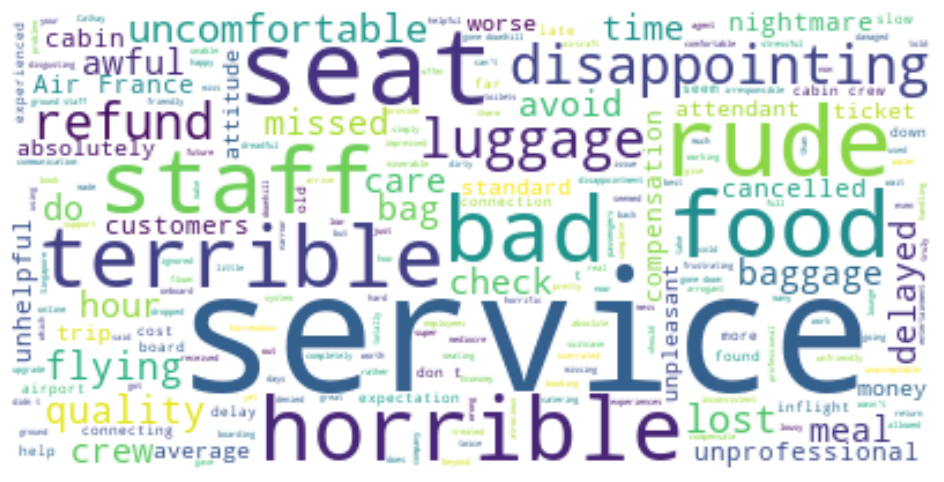

In [81]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# Filter the polarity_df DataFrame for negative sentiment scores greater than 0.5
negative_reviews = polarity_df[(polarity_df['negative'] > 0.5) & (polarity_df['Class'] == 'Economy Class')]

# Concatenate the review content into a single string
text = ' '.join(negative_reviews['Review Content'])

# List of skip words
skip_words = ["recommend", "as", "bit", "able", "up", "day", "both", "about", "let", "offered", "that", "won't", "its", "refused", "know", "feel", "plane", "one", "will", "still", "flights", "could", "left", "use", "over", "such", "what", "dont", "pay", "being", "passenger", "ife", "overall", "like", "any", "no", "don't", "on", "with", "you", "or", "get", "would", "didn't", "really", "am", "people", "have", "our", "cannot", "been", "has", "are", "fly", "with", "had", "we", "be", "their", "most", "an", "were", "to", "lack", "ever", "me", "of", "good", "at", "turkish", "in", "customer", "never", "it", "all", "below", "so", "too", "us", "did", "my", "for", "they", "is", "disappointed", "poor", "was", "I", "flight", "airline", "emirates", "worst", "experience", "airlines", "and", "not", "a", "the", "this", "very", "them", "again", "travel", "from", "nothing", "quite", "by", "extremely"]

# Create a WordCloud object
wordcloud = WordCloud(background_color='white', stopwords=skip_words).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [108]:
polarity_df['Sentiment Recommendation'] = (polarity_df['positive'] > 0.9)

# Calculate the accuracy of the sentiment recommendation
accuracy = polarity_df[polarity_df['Recommended'] == polarity_df['Sentiment Recommendation']].shape[0] / polarity_df.shape[0]

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6949382716049383


In [109]:
# Filter the polarity_df DataFrame for 'Economy Class' and group by 'Airline'
grouped_pdf = polarity_df[polarity_df['Class'] == 'Economy Class'].groupby('Airline').agg({'Recommended': 'mean', 'Sentiment Recommendation': 'mean'}).reset_index()

grouped_pdf['Recommended'] = grouped_pdf['Recommended'] * 100
grouped_pdf['Sentiment Recommendation'] = grouped_pdf['Sentiment Recommendation'] * 100

grouped_pdf['Recommended'] = grouped_pdf['Recommended'].round(2)
grouped_pdf['Sentiment Recommendation'] = grouped_pdf['Sentiment Recommendation'].round(2)

# Create a bar chart
fig = px.bar(grouped_pdf, x='Airline', y='Sentiment Recommendation', title="Likelihood of reviewers recommending the airlines to others (Economy Class)")

fig.update_layout(
    yaxis_title="Recommendation Likelihood (%)",
    yaxis_range=[0, 100]
)

# Show the bar chart
fig.show()

In [153]:
# Quit the session
spark.stop()